### Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split

Data Source:

https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics

In [2]:
df = pd.read_csv("daily-treasury-rates.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    8100 non-null   object 
 1   1 Mo    5200 non-null   float64
 2   2 Mo    895 non-null    float64
 3   3 Mo    8096 non-null   float64
 4   6 Mo    8099 non-null   float64
 5   1 Yr    8099 non-null   float64
 6   2 Yr    8099 non-null   float64
 7   3 Yr    8099 non-null   float64
 8   5 Yr    8099 non-null   float64
 9   7 Yr    8099 non-null   float64
 10  10 Yr   8099 non-null   float64
 11  20 Yr   7160 non-null   float64
 12  30 Yr   7105 non-null   float64
dtypes: float64(12), object(1)
memory usage: 822.8+ KB


In [3]:
df.drop(["1 Mo"], axis = 1, inplace = True)
df.drop(["2 Mo"], axis = 1, inplace = True)
df.dropna(inplace = True)
df.isnull().sum()

Date     0
3 Mo     0
6 Mo     0
1 Yr     0
2 Yr     0
3 Yr     0
5 Yr     0
7 Yr     0
10 Yr    0
20 Yr    0
30 Yr    0
dtype: int64

In [4]:
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.sort_values(by = "Date", inplace = True)
df

,Date,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
7160,1993-10-01,2.98,3.11,3.35,3.84,4.18,4.72,5.03,5.34,6.12,5.98
7159,1993-10-04,3.02,3.17,3.35,3.85,4.16,4.71,5.04,5.34,6.10,5.99
7158,1993-10-05,3.06,3.20,3.38,3.86,4.18,4.72,5.05,5.35,6.12,6.01
7157,1993-10-06,3.04,3.19,3.36,3.85,4.16,4.70,5.05,5.35,6.12,6.01
7156,1993-10-07,3.05,3.17,3.35,3.83,4.15,4.69,5.05,5.33,6.11,6.01
...,...,...,...,...,...,...,...,...,...,...,...
4,2022-05-09,0.92,1.43,1.99,2.61,2.81,2.95,3.04,3.05,3.38,3.19
3,2022-05-10,0.89,1.44,2.01,2.62,2.81,2.91,2.99,2.99,3.31,3.12
2,2022-05-11,0.91,1.43,1.99,2.66,2.81,2.89,2.94,2.91,3.25,3.05
1,2022-05-12,0.96,1.44,1.96,2.56,2.73,2.81,2.86,2.84,3.22,3.00


### Feature Engineering

In [5]:
# configure parameters
hist_window = 20
forecast_horizon = 5
train_test_split_ratio = 0.15
features = ["3 Mo", "6 Mo", "1 Yr", "2 Yr", "3 Yr", "5 Yr", "7 Yr", "10 Yr", "20 Yr", "30 Yr"]
target = "10 Yr"

def data_prep(data, target, start, end, window, horizon, incre_by_horizon = False):
    X, y = [], []
    start = start + window
    if end is None:
        end = len(data) - horizon
    incre = horizon if incre_by_horizon is True else 1
    for i in range(start, end, incre):
        indices = range(i - window, i)
        X.append(data[indices])
        indicey = range(i, i + horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y) 

X, y = data_prep(np.array(df[features]), np.array(df[target]), 0, None, hist_window, forecast_horizon)
X, X_test, y, y_test = train_test_split(X, y, test_size = train_test_split_ratio, shuffle = True, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = train_test_split_ratio, shuffle = True, random_state = 42)

print("train size: {0}".format(len(X_train)))
print("validation size: {0}".format(len(X_val)))
print("test size: {0}".format(len(X_test)))
print("X_train shape: {0}".format(X_train.shape))
print("y_train shape: {0}".format(y_train.shape))

train size: 4434
validation size: 783
test size: 921
X_train shape: (4434, 20, 10)
y_train shape: (4434, 5)


### Modeling

In [6]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

# configure parameters
epochs = 20 
batch_size = 100
embedding_size = 400
dropout_ratio = 0.2

# compile model
model = Sequential()
model.add(LSTM(embedding_size, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(dropout_ratio))
model.add(LSTM(embedding_size))
model.add(Dropout(dropout_ratio))
model.add(Dense(forecast_horizon))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 400)           657600    
                                                                 
 dropout (Dropout)           (None, 20, 400)           0         
                                                                 
 lstm_1 (LSTM)               (None, 400)               1281600   
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 5)                 2005      
                                                                 
Total params: 1,941,205
Trainable params: 1,941,205
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
45/45 [==============================] - 17s 305ms/step - loss: 1.1512 - val_loss: 0.0401
Epoch 2/20
45/45 [==============================] - 13s 294ms/step - loss: 0.0935 - val_loss: 0.0267
Epoch 3/20
45/45 [==============================] - 15s 324ms/step - loss: 0.0777 - val_loss: 0.0153
Epoch 4/20
45/45 [==============================] - 14s 315ms/step - loss: 0.0734 - val_loss: 0.0231
Epoch 5/20
45/45 [==============================] - 13s 298ms/step - loss: 0.0750 - val_loss: 0.0235
Epoch 6/20
45/45 [==============================] - 13s 291ms/step - loss: 0.0641 - val_loss: 0.0242
Epoch 7/20
45/45 [==============================] - 13s 293ms/step - loss: 0.0608 - val_loss: 0.0133
Epoch 8/20
45/45 [==============================] - 13s 292ms/step - loss: 0.0590 - val_loss: 0.0342
Epoch 9/20
45/45 [==============================] - 13s 290ms/step - loss: 0.0665 - val_loss: 0.0249
Epoch 10/20
45/45 [==============================] - 13s 291ms/step - loss: 0.0569 - val_lo

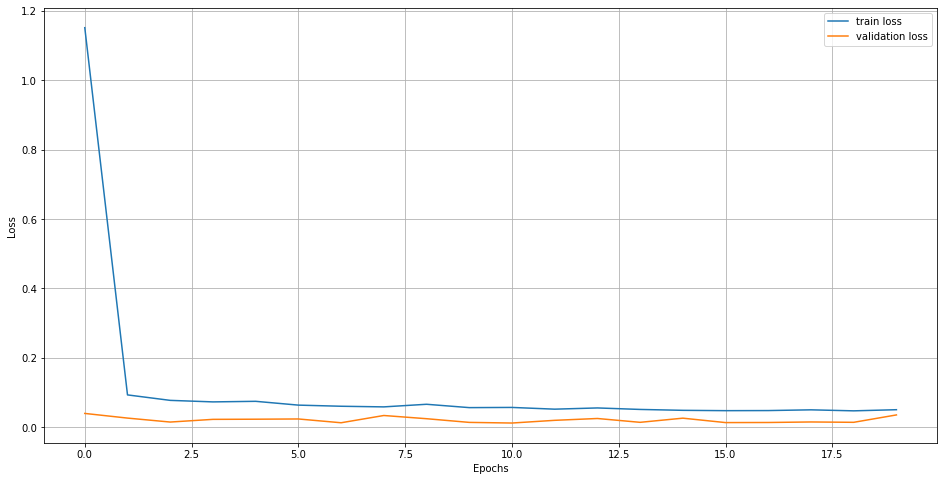

In [7]:
# train model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# save model
model.save("lstm_hist_{0}_fore_{1}.h5".format(hist_window, forecast_horizon))

# plot loss curves
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [8]:
def forecast_yield(df, hist_window, forecast_horizon, start_forecast_date):
    # load model
    model = load_model("lstm_hist_{0}_fore_{1}.h5".format(hist_window, forecast_horizon))
    
    # fetch & prepare data
    data = df[df["Date"] >= start_forecast_date - timedelta(hist_window)]
    X, y = data_prep(np.array(data[features]), np.array(data[target]), 0, None, hist_window, forecast_horizon, True)

    # forecast
    preds = model.predict(X)

    # reshape output
    y = y.reshape(y.shape[0] * y.shape[1])
    preds = preds.reshape(preds.shape[0] * preds.shape[1])
    error = mean_squared_error(y, preds)
    dates = data["Date"][hist_window : hist_window + len(y)]

    # plot output
    plt.figure(figsize=(30,15))
    plt.grid(True)
    plt.plot(dates, y, label = "Ground Truth", color = "green", marker='o')

    mark = [i for i in range(0, len(preds), forecast_horizon)]
    plt.plot(dates, preds, markevery = mark, label = "Forecast Begins", color = "red", marker='D')

    plt.gcf().autofmt_xdate()
    plt.title("Forecast Yield (yield = {0}, forecast start on {1}, historical window = {2} days, forecast horizon = {3} days, mean-squared-error = {4})"\
              .format(target, start_forecast_date, hist_window, forecast_horizon, round(error, 4)))
    plt.xlabel("Date")
    plt.ylabel("{0} Yield".format(target))
    plt.legend()
    plt.show()

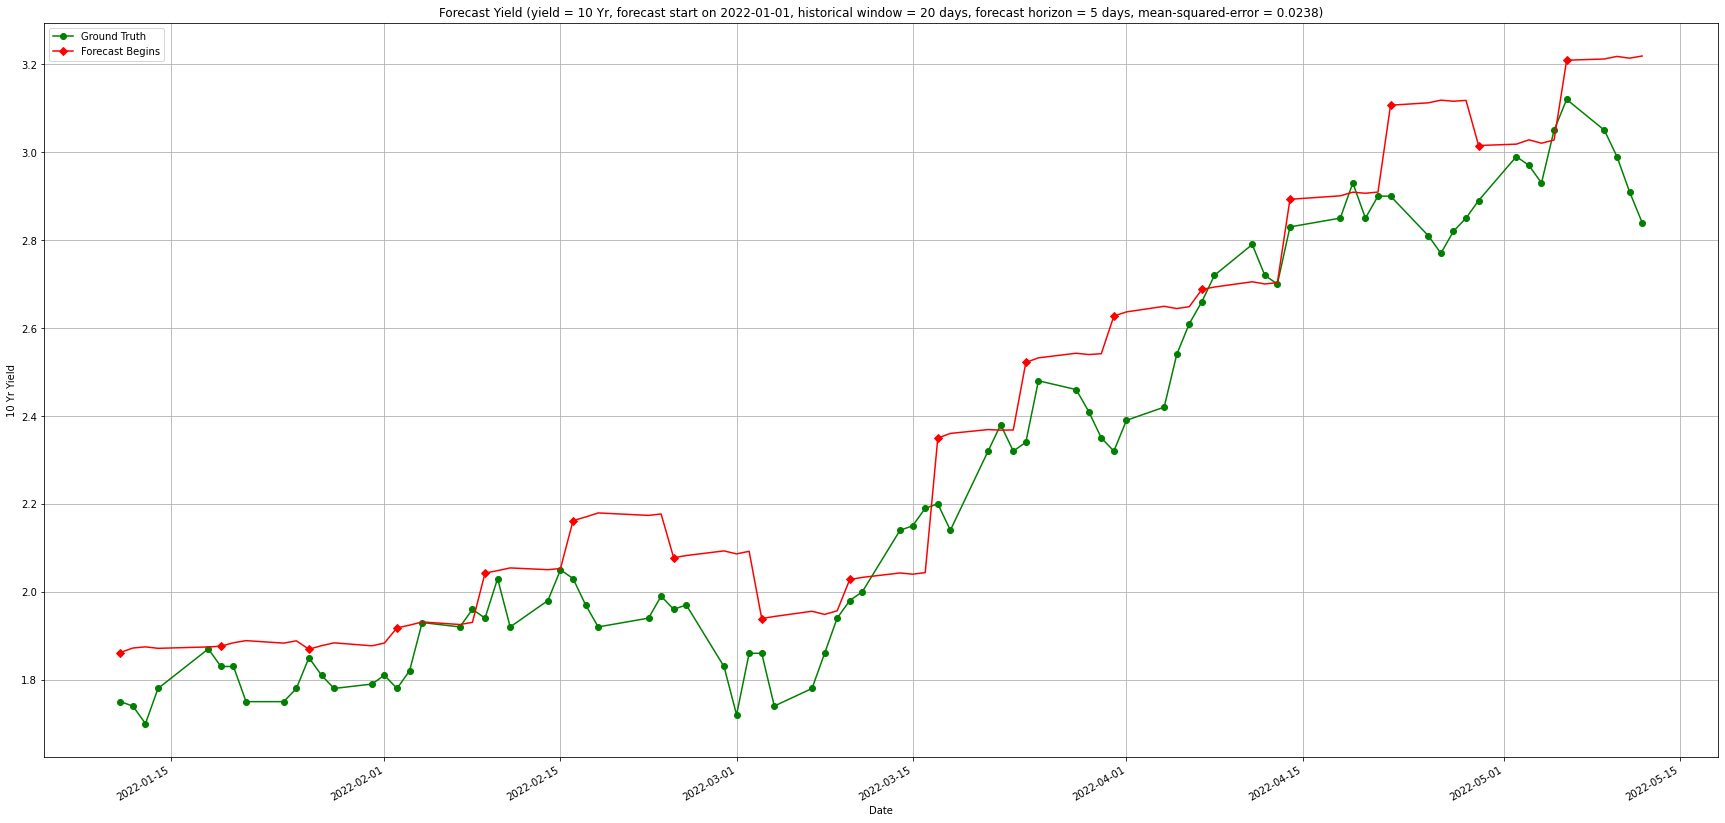

In [9]:
forecast_yield(df, 20, 5, datetime.date(2022, 1, 1))